This notebook is intended to show how to create useful visualizations of a GoExplore run.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter

%matplotlib inline

import networkx as nx
from tqdm.notebook import tqdm
from IPython.display import HTML, display

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load map data

In [ ]:
def load_map(filename):
  with open(filename, 'r') as f:
      lines = f.readlines()

  return np.array([list(line.strip()) for line in lines if '.' in line or 'T' in line or '@' in line])

arena_map = load_map("Go-Explore MapsTest\arena.map")
arena2_map = load_map("Go-Explore MapsTest\ca_cave.map")

Show Map Data

58085


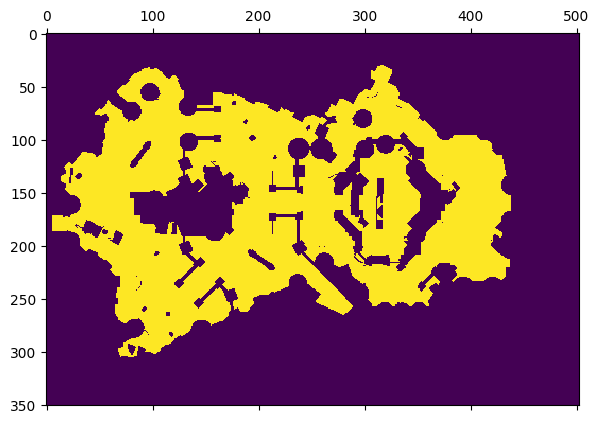

In [ ]:
map_data = arena_map
plt.matshow(map_data=='.');

possible_moves = []
for i, index in enumerate(map_data):
  for j, value in enumerate(index):
    if value == ".":
      possible_moves.append((i,j))

print(len(possible_moves))

#Graph Construction


In [ ]:
# Construct a graph from positions list
def construct_graph(input, inputV):
    G = nx.Graph()
    for i,pos in enumerate(input):
      # Add nodes and edges between consecutive arrays
      nodes = [(p[0],p[1]) for p in pos]
      #print(edgess)
      for node in nodes:
          G.add_node(node, visit=inputV[node])  # Add visit attribute if node is present in inputV
      #G.add_nodes_from(nodes, visit = 1) #visit is an attribute of every node that keeps track of how many visits
      if i > 0:
      # Add edges between consecutive nodes in the current array
        edges = [((input[i-1][j][0],input[i-1][j][1]),(input[i][j][0],input[i][j][1]))for j,edge in enumerate(pos)]
        G.add_edges_from(edges,color = 'red')

    # Print nodes and edges of the graph
    return G

# Compute eigenvalue centrality
def compute_eigenvalue_centrality(G):
    eigenvalue_centrality = nx.eigenvector_centrality_numpy(G)
    return eigenvalue_centrality

def Compute_Distribution(G): #also computes centrality first
  eigenvalue_centrality = nx.eigenvector_centrality_numpy(G)
  total_centrality = sum(eigenvalue_centrality.values())
  probability_distribution = {node: centrality / total_centrality for node, centrality in eigenvalue_centrality.items()}
  return probability_distribution

# Generic Go Explore algorithm

In [ ]:
def go_explore(strategy, steps=100, teleport_interval=10,history_interval = 100,seed=0):
  state = random.choice(possible_moves)
  first_visit_time = np.full(map_data.shape, np.nan)
  visit_counts = np.full(map_data.shape, 0, dtype='int32')
  visit_counts_history = []
  visited_set = []
  CellStates : dict = {state : 1}
  edges = set()

  def visit(t):
    if state not in visited_set:
      visited_set.append(state)
      first_visit_time[state] = t
      CellStates[state] = 1
    else:
      CellStates[state] +=  1
    visit_counts[state] += 1

  def teleport():
    nonlocal state
    if 'on_teleport' == strategy:
      if visited_set:
        state = random.choice(list(visited_set))
      else:
        state = possible_moves[0]

    if 'Least_visits' == strategy:
      if visited_set:
        state = Least_visits()

    if 'Lowest_EigenVectorH' == strategy:
      if visited_set:
        state = Lowest_EigenVectorH()


  def Least_visits():
    return min(visited_set, key=lambda s: visit_counts[s])

  def Lowest_EigenVectorH():
    NGraph = construct_graph([list(visited_set)],CellStates)
    if (NGraph.number_of_nodes() > 3): #there is a minimum number of nodes a graph in order to calculate centrality.
      eigenvalue_centrality = compute_eigenvalue_centrality(NGraph)
      sorted_nodes = sorted(((v, c) for v, c in eigenvalue_centrality.items()), key=lambda x: x[1], reverse = False) #key extracts second element so we sort based on centrality and not node
      #important to note, but there are often 2 nodes with the same centrality score.
      if (NGraph.nodes[(sorted_nodes[0][0][0],sorted_nodes[0][0][1])]['visit']) <= (NGraph.nodes[(sorted_nodes[1][0][0],sorted_nodes[1][0][1])]['visit']):
        return (sorted_nodes[0][0][0],sorted_nodes[0][0][1]) #just decided to pick the first one if it has less visits than the second node
      else:
        return (sorted_nodes[1][0][0],sorted_nodes[1][0][1]) #pick the second node

  def move():
    nonlocal state

    directions = []

    if state[0] < map_data.shape[0] - 1:
      directions.append((1,0))
    if state[0] > 0:
      directions.append((-1,0))
    if state[1] < map_data.shape[1] - 1:
      directions.append((0,1))
    if state[1] > 0:
      directions.append((0,-1))

    destinations = []
    for dx,dy in directions:
      if map_data[state[0]+dx, state[1]+dy] != 'T' and map_data[state[0]+dx, state[1]+dy] != '@':
        destinations.append((state[0]+dx, state[1]+dy))

    next_state = random.choice(destinations)
    map_data[next_state] = '0'
    edges.add((state, next_state))
    state = next_state

  random.seed(seed)
  for t in tqdm(range(steps)):
    if t % history_interval == 0:
      visit_counts_history.append(visit_counts.copy())
    if t % teleport_interval == 0:
      teleport()
    else:
      move()
    visit(t)


  counter = (map_data == '.').sum()
  print(counter)
  print((len(possible_moves) - counter)/ steps)
  return locals()

#Different Strategies

# Experimental run

In [ ]:
strategy = 'Least_visits'
res = go_explore(strategy, steps=100_000,teleport_interval=10, seed=0)
#5955
#0.18356
#18420
#0.05
#21720
#0.02591

  0%|          | 0/100000 [00:00<?, ?it/s]

34793
0.23292


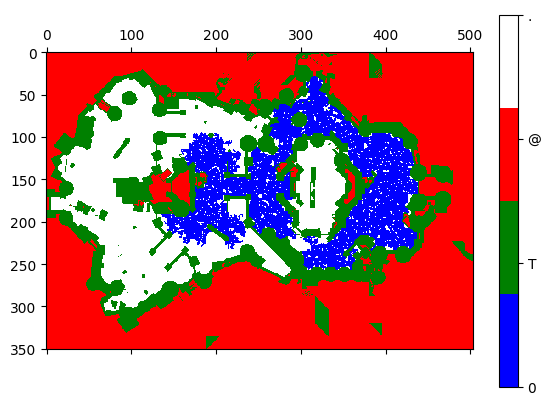

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Create masks for each condition
mask_0 = map_data == '0'
mask_T = map_data == 'T'
mask_At = map_data == '@'
mask_d = map_data == '.'

# Create a composite mask combining all individual masks
composite_mask = np.zeros_like(map_data, dtype=int)
composite_mask[mask_0] = 1
composite_mask[mask_T] = 2
composite_mask[mask_At] = 3
composite_mask[mask_d] = 4

# Define custom colors for each mask
colors = ['blue', 'green', 'red', 'white']
cmap = LinearSegmentedColormap.from_list('CustomColors', colors, N=4)

# Plot the composite mask using the custom colormap
plt.matshow(composite_mask, cmap=cmap)

# Show colorbar to indicate the mapping of colors to masks
cbar = plt.colorbar(ticks=[1, 2, 3, 4])
cbar.set_ticklabels(['0', 'T', '@', '.'])

# Show the plot
plt.show()


# Visualization

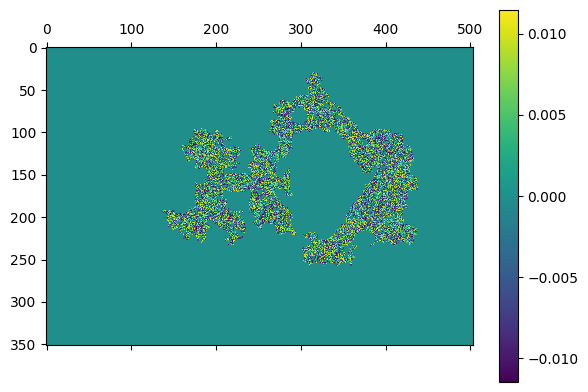

In [ ]:
#g = nx.Graph()
#g.add_edges_from(res['edges'])
#g.add_edges_from([(v,u) for (u,v) in res['edges']])

g = construct_graph([list(res['visited_set'])],res['CellStates'])

centrality_scores = np.zeros(map_data.shape)
centrality = nx.eigenvector_centrality_numpy(g)
for node, value in centrality.items():
  centrality_scores[node] = value

plt.matshow(centrality_scores);
plt.colorbar();

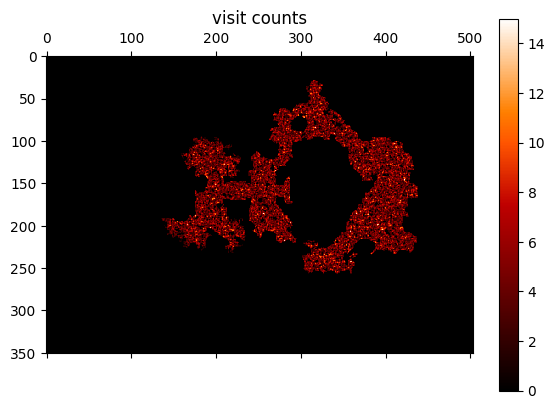

In [ ]:
plt.matshow(res['visit_counts'], cmap="gist_heat");
plt.title("visit counts");
plt.colorbar();

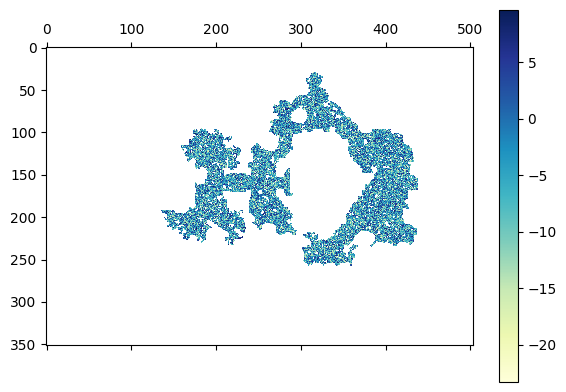

In [ ]:
n = len(res['visit_counts_history'])
virtual_counts = n * (centrality_scores / centrality_scores.sum())
interest = -(res['visit_counts'] + virtual_counts)
interest = np.where(res['visit_counts']==0,-np.inf,interest)
plt.matshow(interest, cmap='YlGnBu');
plt.colorbar();

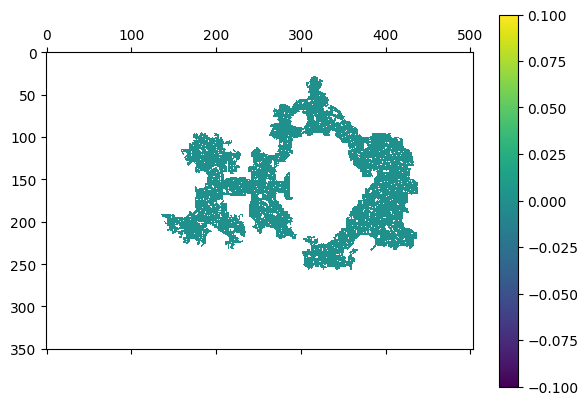

In [ ]:
r = np.argsort(np.argsort(res['visit_counts'].ravel())).reshape(map_data.shape)
plt.matshow(np.where(res['visit_counts']>0,r<1500,np.nan));
plt.colorbar();

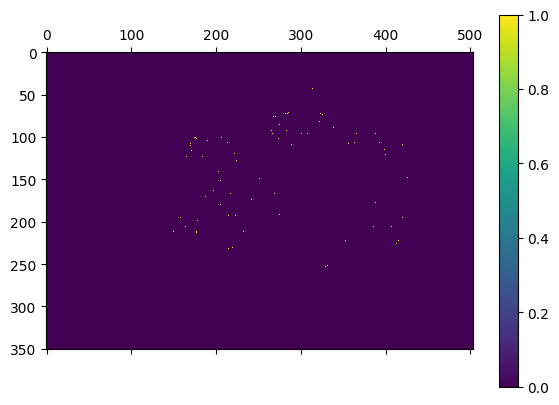

In [ ]:
r = np.argsort(np.argsort(-interest.ravel())).reshape(map_data.shape)
plt.matshow(r<100);
plt.colorbar();

  0%|          | 0/10 [00:00<?, ?it/s]

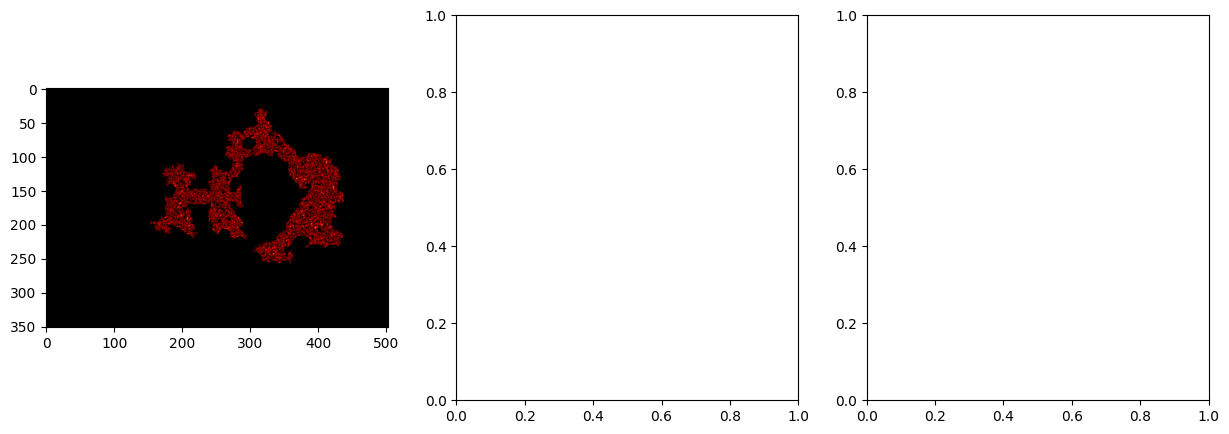

In [ ]:
moviewriter = FFMpegWriter()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

im = axs[0].imshow(res['visit_counts_history'][-1], cmap="gist_heat")

with moviewriter.saving(fig, 'myfile.mp4', dpi=100):
    for visit_counts in tqdm(res['visit_counts_history'][::10]):
        im.set_data(visit_counts)
        moviewriter.grab_frame()
